# Evaluting Model Performance
- Accuracy
- Per-class precision and recall
- Confusion matrix
- F1-score per class 
- Macro-averaged precision, recall and F1
- ROC curves (one versus all) for every single class
- Precision-recall curve for every single class

In [2]:
import pandas as pd
import numpy as np
import torch
import os
from torchvision import transforms

# from scripts.train import model_create
from tqdm import tqdm
from PIL import Image

model_checkpoint_path = "/media/hdd1/neo/MODELS/2024-06-11  DeepHemeRetrain non-frog feature deploy/1/version_0/checkpoints/epoch=499-step=27500.ckpt"
data_path = "/media/hdd1/neo/pooled_deepheme_data/val"
save_dir = "/media/hdd1/neo/pooled_deepheme_data"

cellnames = [
    "B1",
    "B2",
    "E1",
    "E4",
    "ER1",
    "ER2",
    "ER3",
    "ER4",
    "ER5",
    "ER6",
    "L2",
    "L4",
    "M1",
    "M2",
    "M3",
    "M4",
    "M5",
    "M6",
    "MO2",
    "PL2",
    "PL3",
    "U1",
    "U4",
]

cellnames = ["M1", "not-M1"]

## Compiling Data
We start by compiling the data. The expected input is a model checkpoint path and a path to the testing or validation data folder structued in the imagenet format or whatever format renderable by the intended dataloader. We are going to compile the model's outputs using a GPU And save as a pandas dataframe.

In [1]:
model = model_create(path=model_checkpoint_path)


def predict_batch(pil_images, model):
    # Define the transformations
    image_transforms = transforms.Compose(
        [
            transforms.Resize(96),
            transforms.ToTensor(),
        ]
    )

    # Apply transformations to each image and create a batch
    batch = torch.stack([image_transforms(image).float() for image in pil_images])

    # Move the batch to the GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch = batch.to(device)

    # Set the model to evaluation mode and make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(batch)

        # apply softmax to the outputs
        outputs = torch.nn.functional.softmax(outputs, dim=1)

    # Process each output as in the original code snippet
    predictions = []
    for output in outputs:
        output = output.detach().cpu().numpy()
        predictions.append(tuple(output))

    # Return a list of predictions in the same order as the input images
    return predictions


def predict_image(pil_image, model):
    pil_images = [pil_image]

    # Call the predict_batch function
    predictions = predict_batch(pil_images, model)

    # Return the first prediction
    return predictions[0]


result_df_dct = {
    "image_path": [],
    "label": [],
}

for cellname in cellnames:
    result_df_dct[cellname] = []

for cellname in tqdm(cellnames, desc="Processing cell types"):
    image_dir_path = os.path.join(data_path, cellname)

    # find all the .jpg, .jpeg, .png files in the directory
    image_paths = [
        os.path.join(image_dir_path, f)
        for f in os.listdir(image_dir_path)
        if f.endswith(".jpg") or f.endswith(".jpeg") or f.endswith(".png")
    ]

    for image_path in tqdm(image_paths, desc="Processing images"):
        image = Image.open(image_path)
        prediction = predict_image(image, model)

        result_df_dct["image_path"].append(image_path)
        result_df_dct["label"].append(cellname)
        for i in range(len(cellnames)):
            result_df_dct[cellnames[i]].append(prediction[i])

result_df = pd.DataFrame(result_df_dct)

# save the result as a csv file in the save_dir
result_df.to_csv(os.path.join(save_dir, "predictions.csv"), index=False)

NameError: name 'model_create' is not defined

Overall Accuracy: 0.9568

Class Accuracies:
label
M1        0.714493
not-M1    0.976719
dtype: float64

Macro Average of Per Class Accuracy: 0.8456


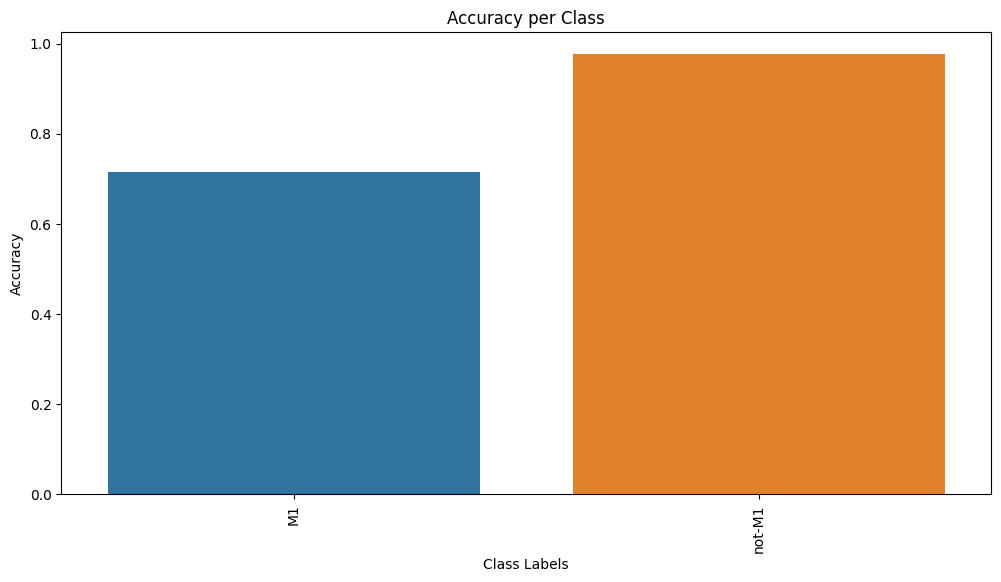

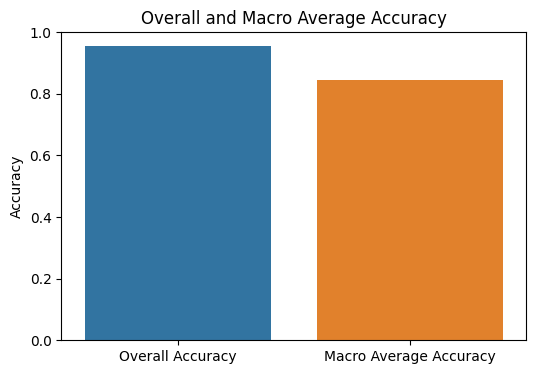

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

prediction_path = "/Users/neo/Documents/Research/MODELS/2024-06-27 M1 versus everything else (all 22 other classes) epochs=500/predictions.csv"
# prediction_path = "/Users/neo/Documents/Research/MODELS/2024-06-24 DeepHeme M1 MO2 M2 L2 ER1 epochs=500/predictions.csv"
data = pd.read_csv(prediction_path)

# Identify the columns with predicted probabilities
probability_columns = data.columns.difference(['image_path', 'label'])

# Step 1: Calculate the predicted class for each instance
data['predicted_class'] = data[probability_columns].idxmax(axis=1)

# Step 2: Compute the overall accuracy
overall_accuracy = (data['label'] == data['predicted_class']).mean()

# Step 3: Compute the accuracy for each class
class_accuracies = data.groupby('label').apply(lambda x: (x['label'] == x['predicted_class']).mean())

# Step 4: Compute the macro average of per class accuracy
macro_average_accuracy = class_accuracies.mean()

# Display the results
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print("\nClass Accuracies:")
print(class_accuracies)
print(f"\nMacro Average of Per Class Accuracy: {macro_average_accuracy:.4f}")

# Plot the class accuracies
plt.figure(figsize=(12, 6))
sns.barplot(x=class_accuracies.index, y=class_accuracies.values)
plt.xlabel('Class Labels')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.xticks(rotation=90)
plt.show()

# Plot the overall and macro average accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=['Overall Accuracy', 'Macro Average Accuracy'], y=[overall_accuracy, macro_average_accuracy])
plt.ylabel('Accuracy')
plt.title('Overall and Macro Average Accuracy')
plt.ylim(0, 1)
plt.show()

Macro Average Precision: 0.7985
Macro Average Recall: 0.7983

Per Class Precision and Recall:
  Class  Precision    Recall
0   ER1   0.766082  0.829114
1    L2   0.896552  0.900133
2    M1   0.721311  0.701449
3    M2   0.859956  0.839744
4   MO2   0.748428  0.721212


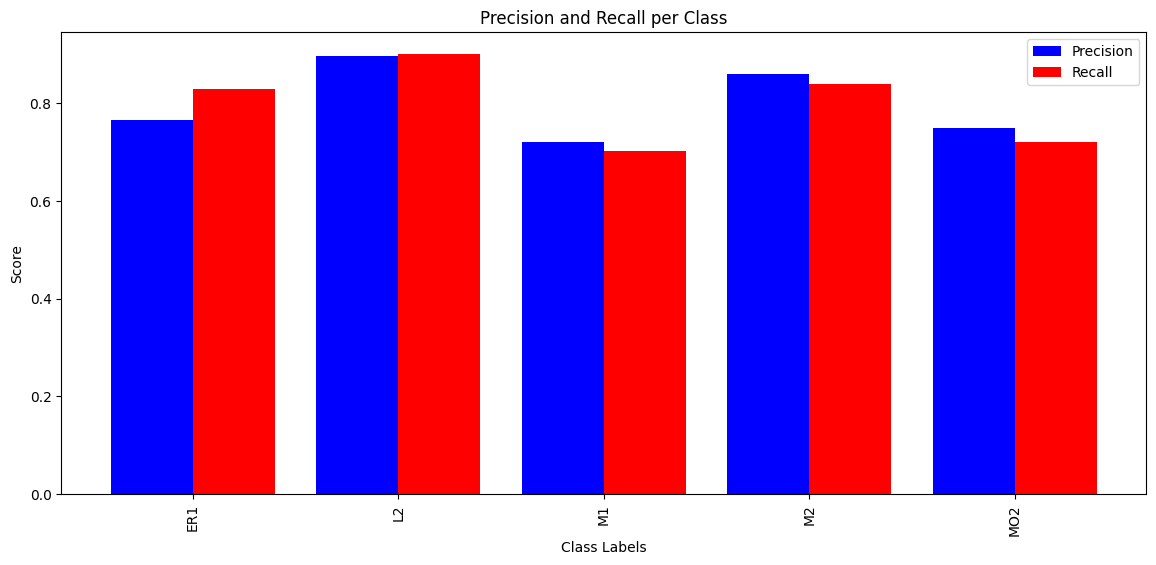

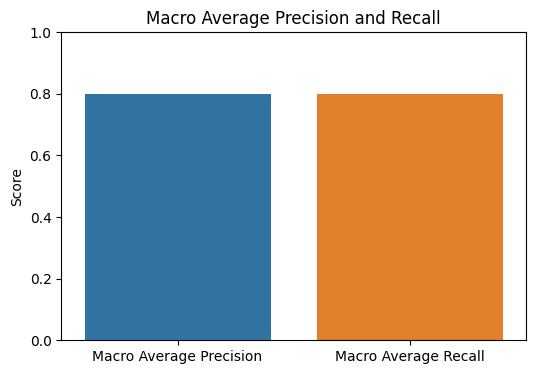

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

# Identify the columns with predicted probabilities (numeric columns only)
probability_columns = data.select_dtypes(include='number').columns

# Step 1: Calculate the predicted class for each instance
data['predicted_class'] = data[probability_columns].idxmax(axis=1)

# Step 2: Compute the confusion matrix and extract precision and recall
precision, recall, _, _ = precision_recall_fscore_support(data['label'], data['predicted_class'], average=None, labels=probability_columns)

# Create a DataFrame for precision and recall
metrics_df = pd.DataFrame({
    'Class': probability_columns,
    'Precision': precision,
    'Recall': recall
})

# Compute the macro average of per class precision and recall
macro_avg_precision = metrics_df['Precision'].mean()
macro_avg_recall = metrics_df['Recall'].mean()

# Display the results
print(f"Macro Average Precision: {macro_avg_precision:.4f}")
print(f"Macro Average Recall: {macro_avg_recall:.4f}")

print("\nPer Class Precision and Recall:")
print(metrics_df)

# Plot the precision and recall for each class side by side
plt.figure(figsize=(14, 6))
width = 0.4  # width of the bars
x = metrics_df.index

plt.bar(x - width/2, metrics_df['Precision'], width=width, label='Precision', color='b')
plt.bar(x + width/2, metrics_df['Recall'], width=width, label='Recall', color='r')

plt.xlabel('Class Labels')
plt.ylabel('Score')
plt.title('Precision and Recall per Class')
plt.xticks(ticks=x, labels=metrics_df['Class'], rotation=90)
plt.legend()
plt.show()

# Plot the macro average precision and recall
plt.figure(figsize=(6, 4))
sns.barplot(x=['Macro Average Precision', 'Macro Average Recall'], y=[macro_avg_precision, macro_avg_recall])
plt.ylabel('Score')
plt.title('Macro Average Precision and Recall')
plt.ylim(0, 1)
plt.show()

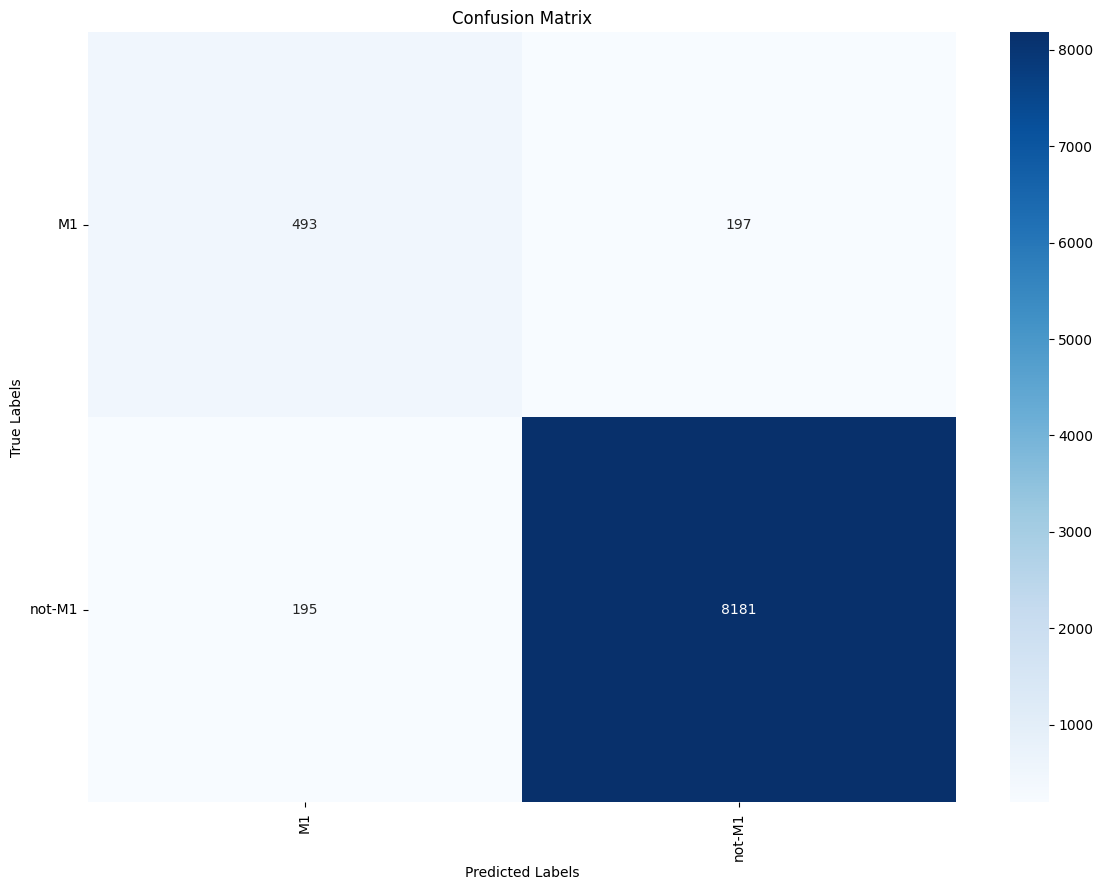

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix


# Identify the columns with predicted probabilities (numeric columns only)
probability_columns = data.select_dtypes(include='number').columns

# Step 1: Calculate the predicted class for each instance
data['predicted_class'] = data[probability_columns].idxmax(axis=1)

# Step 2: Compute the confusion matrix
conf_matrix = confusion_matrix(data['label'], data['predicted_class'], labels=probability_columns)

# Plot the confusion matrix
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=probability_columns, yticklabels=probability_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Macro Average F1-Score: 0.7980

Per Class F1-Score:
  Class  F1-Score
0   ER1  0.796353
1    L2  0.898339
2    M1  0.711242
3    M2  0.849730
4   MO2  0.734568


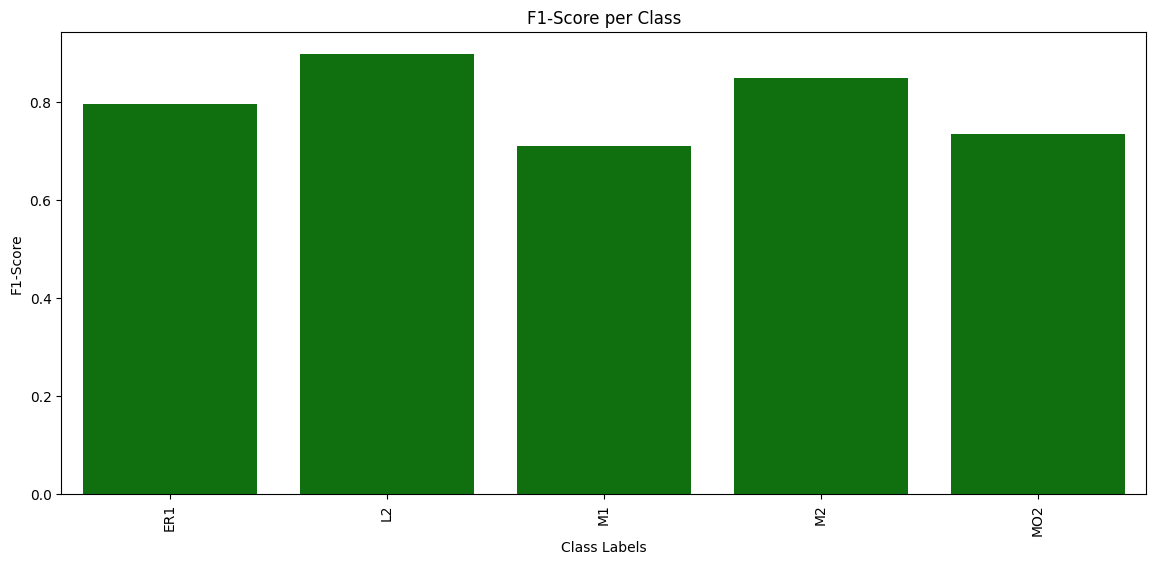

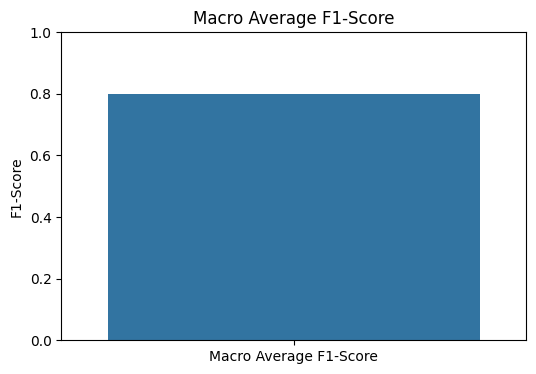

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# Load the dataset
# file_path = "/Users/neo/Documents/DATA/deephemev3_val_predictions.csv"
file_path = "/Users/neo/Documents/Research/MODELS/2024-06-24 DeepHeme M1 MO2 M2 L2 ER1 epochs=500/predictions.csv"
data = pd.read_csv(file_path)

# Identify the columns with predicted probabilities (numeric columns only)
probability_columns = data.select_dtypes(include='number').columns

# Step 1: Calculate the predicted class for each instance
data['predicted_class'] = data[probability_columns].idxmax(axis=1)

# Step 2: Compute the F1-score for each class
f1_scores = f1_score(data['label'], data['predicted_class'], average=None, labels=probability_columns)

# Create a DataFrame for F1-scores
f1_df = pd.DataFrame({
    'Class': probability_columns,
    'F1-Score': f1_scores
})

# Compute the macro average of per class F1-score
macro_avg_f1 = f1_df['F1-Score'].mean()

# Display the results
print(f"Macro Average F1-Score: {macro_avg_f1:.4f}")

print("\nPer Class F1-Score:")
print(f1_df)

# Plot the F1-score for each class
plt.figure(figsize=(14, 6))
sns.barplot(x='Class', y='F1-Score', data=f1_df, color='g')
plt.xlabel('Class Labels')
plt.ylabel('F1-Score')
plt.title('F1-Score per Class')
plt.xticks(rotation=90)
plt.show()

# Plot the macro average F1-score
plt.figure(figsize=(6, 4))
sns.barplot(x=['Macro Average F1-Score'], y=[macro_avg_f1])
plt.ylabel('F1-Score')
plt.title('Macro Average F1-Score')
plt.ylim(0, 1)
plt.show()


In [ ]:
import pandas as pd
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load the dataset
# file_path = '/Users/neo/Documents/DATA/deephemev3_val_predictions.csv'
file_path ="/Users/neo/Documents/Research/MODELS/2024-06-24 DeepHeme M1 MO2 M2 L2 ER1 epochs=500/predictions.csv"
data = pd.read_csv(file_path)

# Identify the columns with predicted probabilities (numeric columns only)
probability_columns = data.select_dtypes(include='number').columns

# Binarize the labels
labels = data['label']
binarized_labels = label_binarize(labels, classes=probability_columns)

# Prepare the true labels and predicted probabilities
true_labels = binarized_labels
predicted_probabilities = data[probability_columns].values

# Create an empty figure
fig = go.Figure()

# Add ROC curves for each class
for i, class_label in enumerate(probability_columns):
    fpr, tpr, _ = roc_curve(true_labels[:, i], predicted_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    fig.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        name=f'Class {class_label} (AUC = {roc_auc:.2f})'
    ))

# Add the diagonal line
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(dash='dash'),
    showlegend=False
))

# Update layout
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curves',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(constrain='domain')
)

# Show the interactive plot
fig.show()

In [ ]:
import pandas as pd
import plotly.graph_objs as go
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Load the dataset
# file_path = '/Users/neo/Documents/DATA/deephemev3_val_predictions.csv'
file_path = "/Users/neo/Documents/Research/MODELS/2024-06-24 DeepHeme M1 MO2 M2 L2 ER1 epochs=500/predictions.csv"
data = pd.read_csv(file_path)

# Identify the columns with predicted probabilities (numeric columns only)
probability_columns = data.select_dtypes(include='number').columns

# Binarize the labels
labels = data['label']
binarized_labels = label_binarize(labels, classes=probability_columns)

# Prepare the true labels and predicted probabilities
true_labels = binarized_labels
predicted_probabilities = data[probability_columns].values

# Create an empty figure
fig = go.Figure()

# Add precision-recall curves for each class
for i, class_label in enumerate(probability_columns):
    precision, recall, _ = precision_recall_curve(true_labels[:, i], predicted_probabilities[:, i])
    avg_precision = average_precision_score(true_labels[:, i], predicted_probabilities[:, i])
    fig.add_trace(go.Scatter(
        x=recall, y=precision,
        mode='lines',
        name=f'Class {class_label} (AP = {avg_precision:.2f})'
    ))

# Update layout
fig.update_layout(
    title='Precision-Recall Curves',
    xaxis_title='Recall',
    yaxis_title='Precision'
)

# Show the interactive plot
fig.show()


In [ ]:
import pandas as pd
import plotly.graph_objs as go

# Load the dataset
# file_path = '/Users/neo/Documents/DATA/deephemev3_val_predictions.csv'
file_path = "/Users/neo/Documents/Research/MODELS/2024-06-24 DeepHeme M1 MO2 M2 L2 ER1 epochs=500/predictions.csv"
data = pd.read_csv(file_path)

# Identify the columns with predicted probabilities (numeric columns only)
probability_columns = data.select_dtypes(include='number').columns

# Step 1: Calculate the predicted class for each instance
data['predicted_class'] = data[probability_columns].idxmax(axis=1)

# Calculate the count of examples in each class for ground truth and predicted
ground_truth_counts = data['label'].value_counts().sort_index()
predicted_counts = data['predicted_class'].value_counts().sort_index()

# Create a DataFrame for plotting
counts_df = pd.DataFrame({
    'Class': ground_truth_counts.index,
    'Ground Truth': ground_truth_counts.values,
    'Predicted': predicted_counts.reindex(ground_truth_counts.index, fill_value=0).values
})

# Create a bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    x=counts_df['Class'],
    y=counts_df['Ground Truth'],
    name='Ground Truth'
))

fig.add_trace(go.Bar(
    x=counts_df['Class'],
    y=counts_df['Predicted'],
    name='Predicted'
))

# Update layout
fig.update_layout(
    title='Number of Examples in Each Class (Ground Truth vs Predicted)',
    xaxis_title='Class Labels',
    yaxis_title='Number of Examples',
    barmode='group'
)

# Show the interactive plot
fig.show()